The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

In [2]:
# Importing instances
# import instances and data
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib as plt
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
# loading train and test DF
df_train = pd.read_csv('readonly/train.csv', encoding='latin', low_memory=False)
df_test = pd.read_csv('readonly/test.csv')
# removing unused features
useless_both = ['clean_up_cost',
                'inspector_name',
                'discount_amount',
                'grafitti_status',                          
                'violator_name',                          
                'zip_code',
                'violation_description',
                'violation_zip_code',
                'disposition',
                'non_us_str_code',
                'fine_amount',
                'admin_fee',
                'state_fee',
                'late_fee',
                'violation_street_number',
                'violation_street_name',
                'mailing_address_str_number',
                'mailing_address_str_name',
                'country']

useless_train =  ['collection_status',
                  'payment_amount',
                  'payment_date',
                  'payment_status',
                  'compliance_detail',
                  'balance_due']

# droping useless features
train_df = df_train.drop(columns=useless_train).dropna(subset=['compliance']).set_index('ticket_id')
train_df.drop(columns=useless_both, inplace=True)
df_test.drop(columns=useless_both, inplace=True)
df_test.set_index('ticket_id', inplace=True)

In [93]:
# replacing dicts
repl_city = {'other':1, 
             'DETROIT': 2, 
             'DEARBORN': 3, 
             'SOUTHFIELD':4, 
             'FARMINGTON HILLS':5}
repl_agency = {'Buildings, Safety Engineering & Env Department': 0,
               'Health Department':1, 
               'Department of Public Works':2,
               'Detroit Police Department':3, 
               'Neighborhood City Halls':4}
repl_vcode = {'9-1-36(a)':0, 
              'other':1, 
              '22-2-88':2,
              '9-1-104':3, 
              '9-1-81(a)':4}

# encoding function
def group_encoding(code, code_list):
    # check if code is in most frequent, if not replace with 'other'
    if code not in code_list:
        code = 'other'
    return code


# feature processing function
def feature_processing(df):
    # Adding days since issued ticket feature
    df['days_since'] = (pd.to_datetime(df  ['hearing_date'])-pd.to_datetime(df['ticket_issued_date'])).dt.days
    #dopping used collumns
    df = df.drop(columns=['hearing_date','ticket_issued_date'])

    # city str uniformization
    df['city'] = df['city'].str.upper()
    
    # Encoding features to most frequent groups
    # Grouping to encode
    violation_cat = ['9-1-36(a)', '9-1-81(a)', '22-2-88', '9-1-104']
    cities_code = ['DETROIT', 'SOUTHFIELD', 'DEARBORN', 'FARMINGTON HILLS']

    # Applying encodig funtion to features
    df['violation_code'] = df['violation_code'].apply(group_encoding, code_list= violation_cat)
    df['city'] = df['city'].apply(group_encoding, code_list = cities_code)

    # encoding states to be onli MI or others
    df.loc[df['state'] != 'MI', 'state'] = 0
    df.loc[df['state'] == 'MI', 'state'] = 1
    # replacing negative days since value with the median
    df.loc[df['days_since'] < 0, 'days_since'] = df.days_since.median()
    df.days_since = df.days_since.fillna(value=54.)

    # Final encoding of features
    df.city = df.city.replace(repl_city)
    df.agency_name = df.agency_name.replace(repl_agency)
    df.violation_code = df.violation_code.replace(repl_vcode)

    return df

In [96]:
# training sets
X = feature_processing(train_df).drop(columns='compliance')
y = feature_processing(train_df)['compliance']

In [97]:
# Starting the model building
# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45, train_size=0.7)

In [102]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=4, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9310733049787341

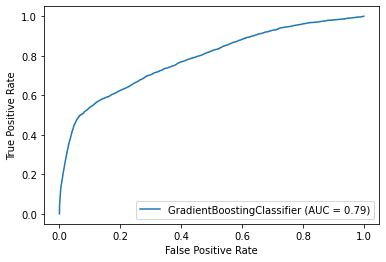

In [103]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf, X_test, y_test)

In [124]:
# getting the assingment probabilities
x_final = feature_processing(df_test)
proba = clf.predict_proba(x_final)[:,1]
x_final['compliance'] = proba
x_final.compliance # value to return

ticket_id
284932    0.073359
285362    0.014829
285361    0.070017
285338    0.117436
285346    0.100747
            ...   
376496    0.002774
376497    0.002774
376499    0.065313
376500    0.065313
369851    0.220443
Name: compliance, Length: 61001, dtype: float64

In [125]:
# final function test
def blight_model():
    # Importing instances
    # import instances and data
    import pandas as pd
    import pandas_profiling
    import numpy as np
    import matplotlib as plt
    from sklearn.metrics import auc
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import GradientBoostingClassifier
    # loading train and test DF
    df_train = pd.read_csv('readonly/train.csv', encoding='latin', low_memory=False)
    df_test = pd.read_csv('readonly/test.csv')
    # removing unused features
    useless_both = ['clean_up_cost', 'inspector_name','discount_amount','grafitti_status',                         'violator_name', 'zip_code','violation_description','violation_zip_code', 'disposition', 'non_us_str_code',
                'fine_amount','admin_fee', 'state_fee','late_fee','violation_street_number',
                'violation_street_name','mailing_address_str_number','mailing_address_str_name','country']

    useless_train =  ['collection_status',  'payment_amount','payment_date','payment_status', 'compliance_detail',              'balance_due']

    # droping useless features
    train_df = df_train.drop(columns=useless_train).dropna(subset=['compliance']).set_index('ticket_id')
    train_df.drop(columns=useless_both, inplace=True)
    df_test.drop(columns=useless_both, inplace=True)
    df_test.set_index('ticket_id', inplace=True)

    # replacing dicts
    repl_city = {'other':1, 
                'DETROIT': 2, 
                'DEARBORN': 3, 
                'SOUTHFIELD':4, 
                'FARMINGTON HILLS':5}
    repl_agency = {'Buildings, Safety Engineering & Env Department': 0,
                'Health Department':1, 
                'Department of Public Works':2,
                'Detroit Police Department':3, 
                'Neighborhood City Halls':4}
    repl_vcode = {'9-1-36(a)':0, 
                'other':1, 
                '22-2-88':2,
                '9-1-104':3, 
                '9-1-81(a)':4}

    # encoding function
    def group_encoding(code, code_list):
        # check if code is in most frequent, if not replace with 'other'
        if code not in code_list:
            code = 'other'
        return code


    # feature processing function
    def feature_processing(df):
        # Adding days since issued ticket feature
        df['days_since'] = (pd.to_datetime(df  ['hearing_date'])-pd.to_datetime(df['ticket_issued_date'])).dt.days
        #dopping used collumns
        df = df.drop(columns=['hearing_date','ticket_issued_date'])

        # city str uniformization
        df['city'] = df['city'].str.upper()
        
        # Encoding features to most frequent groups
        # Grouping to encode
        violation_cat = ['9-1-36(a)', '9-1-81(a)', '22-2-88', '9-1-104']
        cities_code = ['DETROIT', 'SOUTHFIELD', 'DEARBORN', 'FARMINGTON HILLS']

        # Applying encodig funtion to features
        df['violation_code'] = df['violation_code'].apply(group_encoding, code_list= violation_cat)
        df['city'] = df['city'].apply(group_encoding, code_list = cities_code)

        # encoding states to be onli MI or others
        df.loc[df['state'] != 'MI', 'state'] = 0
        df.loc[df['state'] == 'MI', 'state'] = 1
        # replacing negative days since value with the median
        df.loc[df['days_since'] < 0, 'days_since'] = df.days_since.median()
        df.days_since = df.days_since.fillna(value=54.)

        # Final encoding of features
        df.city = df.city.replace(repl_city)
        df.agency_name = df.agency_name.replace(repl_agency)
        df.violation_code = df.violation_code.replace(repl_vcode)

        return df
    
    # training sets
    X = feature_processing(train_df).drop(columns='compliance')
    y = feature_processing(train_df)['compliance']
    # Starting the model building
    # train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45, train_size=0.7)
    
    # Training the model
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=4, random_state=0)
    clf.fit(X_train, y_train)
    #clf.score(X_test, y_test)

    # getting the assingment probabilities
    x_final = feature_processing(df_test)
    proba = clf.predict_proba(x_final)[:,1]
    x_final['compliance'] = proba
    
    return x_final.compliance # value to return

In [126]:
blight_model()

ticket_id
284932    0.073359
285362    0.014829
285361    0.070017
285338    0.117436
285346    0.100747
            ...   
376496    0.002774
376497    0.002774
376499    0.065313
376500    0.065313
369851    0.220443
Name: compliance, Length: 61001, dtype: float64